Group: Algo Fund

1.   20466447 Tommy Sui Sang FUNG
2.   20432828 Dennis Ka Wai LAM
3.   21428395 Jimmy Kim Hung LEE
4.   20432844 Luyan MU
5.   20445857 Tsz Nin NG


# Import libraries and helper functions

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from datetime import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web

# Download the font to display Chinese
!wget https://github.com/kenwkliu/ideas/raw/master/colab/data/simhei.ttf
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
CNFont = FontProperties(fname='/content/simhei.ttf')

# Google colab interactive table
%load_ext google.colab.data_table 
%matplotlib inline

# 20220202: Temp workaround for the pandas upgrade
!pip install --upgrade openpyxl

### Helper functions
# Plot stock pair chart
def plotPair(df, stockA, stockB, sizeX, sizeY):
  ax1 = df[stockA].plot(label=stockA, legend=True, figsize = (sizeX, sizeY))
  ax1.set_ylim(df[stockA].min(), df[stockA].max())

  ax2 = df[stockB].plot(secondary_y=True, label=stockB, legend=True, figsize = (sizeX, sizeY))
  ax2.set_ylim(df[stockB].min(), df[stockB].max())

  ax1.legend(prop=CNFont, loc=2)
  ax2.legend(prop=CNFont, loc=1)

  plt.show()


# Plot all many Pairs at the same time
def plotManyPair(pairsDf):
  for index, row in pairsDf.iterrows():
      print('\n', index, ':', row['stockA'], 'vs', row['stockB'], '(', row['corr'], ')')
      plotPair(stocks, row['stockA'], row['stockB'], SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y)


# Filter the correlated stock pairs with the THRESHOLD
def getCorrelatedPairs(stocksCorr, THRESHOLD_Min=0.95, THRESHOLD_Max=1):
  # filter the pairs with correlation values above the THRESHOLD
  highCorr = stocksCorr[((stocksCorr >= THRESHOLD_Min) & (stocksCorr < THRESHOLD_Max))]
  highCorr = highCorr.unstack().sort_values(ascending=False).drop_duplicates()
  highCorr.dropna(inplace=True)
  highCorrDf = highCorr.to_frame().reset_index()
  highCorrDf.rename(columns = {'level_0':'stockA', 'level_1':'stockB', 0:'corr'}, inplace=True)

  # looks up the sectors for the stocksA and stockB
  cols = ['stockA', 'stockB', 'corr', 'sector_A', 'sector_B']
  pairsDf = highCorrDf.merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockA', right_on='shortName').merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockB', right_on='shortName', suffixes=('_A', '_B'))[cols]
  pairsDf['sameSector'] = (pairsDf['sector_A'] == pairsDf['sector_B'])
  
  return pairsDf


### back test related functions

# based on the reserch data to determind the trading params (Enter/Exit Points)
def researchTradingParams(researchData, stockA, stockB, threshold=0.05, Stop_Loss_Factor=2, dollarValue=10000):
  cols = [stockA, stockB]
  research_df = researchData[cols].copy()
  research_df.dropna(inplace = True)

  tradingParams = {}
  tradingParams['dollarValue'] = dollarValue

  # Calculate avgPxRatio for Exit (convergence)
  research_df['ratio'] = research_df[stockA] / research_df[stockB]
  avgPxRatio = research_df['ratio'].mean()
  tradingParams['avgPxRatio'] = avgPxRatio

  # Calculate shortA_longB_ratio for Entry (Divergence)
  shortA_longB_ratio = avgPxRatio * (1 + threshold)
  tradingParams['shortA_longB_ratio'] = shortA_longB_ratio
  shortA_longB_stop_loss_ratio = avgPxRatio * (1 + Stop_Loss_Factor*threshold)
  tradingParams['shortA_longB_stop_loss_ratio'] = shortA_longB_stop_loss_ratio

  # Calculate longA_shortB_ratio from Entry (Divergence)
  longA_shortB_ratio = avgPxRatio * (1 - threshold)
  tradingParams['longA_shortB_ratio'] = longA_shortB_ratio
  longA_shortB_stop_loss_ratio = avgPxRatio * (1 - Stop_Loss_Factor*threshold)
  tradingParams['longA_shortB_stop_loss_ratio'] = longA_shortB_stop_loss_ratio
  return tradingParams


# Determind the signal and dollarValue in the test data
# signal == -1: Long stockA Short stockB
# signal == 1: Short stockA Long stockB
# signal == 0: flat position
def backTest(testData, tradingParams, stockA, stockB):
  cols = [stockA, stockB]
  backTest_df = testData[cols].copy()
  backTest_df.dropna(inplace = True)

  # Get the tradingParams
  dollarValue = tradingParams['dollarValue']
  avgPxRatio = tradingParams['avgPxRatio']
  shortA_longB_ratio = tradingParams['shortA_longB_ratio']
  longA_shortB_ratio = tradingParams['longA_shortB_ratio']
  shortA_longB_stop_loss_ratio = tradingParams['shortA_longB_stop_loss_ratio']
  longA_shortB_stop_loss_ratio = tradingParams['longA_shortB_stop_loss_ratio']

  # Calculate the Price ratio in backTest_df
  backTest_df['pxRatio'] = backTest_df[stockA] / backTest_df[stockB]
  backTest_df['dollarValue'] = dollarValue
  
  # initialize the signal to 0
  backTest_df['signal'] = 0
  signal = 0

  # Determine the signal in each row of the backTest_df
  for index, row in backTest_df.iterrows():
    pxRatio = row['pxRatio']

    # mark signal = 1 if pxRatio > shortA_longB_ratio (Diverge outside the upper band)
    if shortA_longB_stop_loss_ratio > pxRatio > shortA_longB_ratio:
      signal = 1

    # mark signal = -1 if pxRatio < longA_shortB_ratio (Diverge outside the lower band)
    elif longA_shortB_stop_loss_ratio < pxRatio < longA_shortB_ratio:
      signal = -1

    else:
      # continue to mark signal = 1 if previous signal == 1 and pxRatio > avgPxRatio (Trade entered but not converge back yet)
      if signal == 1 and shortA_longB_stop_loss_ratio > pxRatio > avgPxRatio:
        signal = 1

      # continue to mark signal = -1 if previous signal == -1 and pxRatio < avgPxRatio (Trade entered but not converge back yet)
      elif signal == -1 and longA_shortB_stop_loss_ratio < pxRatio < avgPxRatio:
        signal = -1

      else:
        signal = 0

    backTest_df.loc[index, 'signal'] = signal

  return backTest_df


# determine pSignal and nSignal for up/down markers in plot
# pSignal and nSignal is for displaying the up/down markers in plotting chart only, they're not required for backtest calculation
def addSignalMarker(backTest_df):
  backTest_df['pSignal'] = np.where(backTest_df['signal'] == 1, backTest_df['pxRatio'], np.nan)
  backTest_df['nSignal'] = np.where(backTest_df['signal'] == -1, backTest_df['pxRatio'], np.nan)

  return backTest_df


# Combine the research and backtest for a Portfolio of Pairs
def researchAndBackTestPortfolio(pairsDf, researchData, testData, printOutput=True):
  pairsPortfolioBackTest = []

  for index, row in pairsDf.iterrows():
    stockA, stockB = row['stockA'], row['stockB']
    if printOutput: print(stockA, 'vs', stockB)
    tradingParams = researchTradingParams(researchData, stockA, stockB)
    pairsPortfolioBackTest.append(backTest(testData, tradingParams, stockA, stockB)[[stockA, stockB, 'signal', 'dollarValue']])

  return pairsPortfolioBackTest


# Download and import pairslib for calculating PnL
!wget https://github.com/kenwkliu/ideas/raw/master/colab/pairslib.py
import pairslib

--2022-02-07 01:56:21--  https://github.com/kenwkliu/ideas/raw/master/colab/data/simhei.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/simhei.ttf [following]
--2022-02-07 01:56:22--  https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/simhei.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9751960 (9.3M) [application/octet-stream]
Saving to: ‘simhei.ttf’

simhei.ttf          100%[===================>]   9.30M  --.-KB/s    in 0.06s   

2022-02-07 01:56:22 (148 MB/s) - ‘simhei.ttf’ saved [9751960/9751960]

--2022-02-07 01:56:26--  https://git

# Import libraries and raw data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install --upgrade openpyxl
%load_ext google.colab.data_table 
%matplotlib inline

# Download and import pairslib for calculating PnL
!wget https://github.com/kenwkliu/ideas/raw/master/colab/pairslib.py
import pairslib

# Load the stockInfo, researchData and testData
stocksInfo = pd.read_excel('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/hkStocksQuotes.xlsx')
researchData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/researchHKStocksAdjClosePx.csv', index_col=0)
testData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/testHKStocksAdjClosePx.csv', index_col=0)

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
--2022-02-07 01:56:49--  https://github.com/kenwkliu/ideas/raw/master/colab/pairslib.py
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/pairslib.py [following]
--2022-02-07 01:56:50--  https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/pairslib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2949 (2.9K) [text/plain]
Saving to: ‘pairslib.py.1’

pairslib.py.1       100%[===================>]   2.88K  --.-KB/s    in 0s      

2022-02-07 01:56:50

# Turnover Filtering

In [ ]:
# Select only liquid equity names for the trading purpose
# thus add a new colume 'turnover' 
stocksInfo['turnover'] = round(stocksInfo['regularMarketPreviousClose'] * stocksInfo['averageDailyVolume10Day'])

# Select only EQUITY and turnover is bigger than certain numbers
QUOTE_TYPE = 'EQUITY'
MIN_TURNOVER = 100000000  # 100 millions
SELECTED_COLUMNS = ['code', 'shortName', 'industry', 'sector', 'turnover']

stocksFilteredInfo = stocksInfo[(stocksInfo.quoteType == QUOTE_TYPE) & (stocksInfo.turnover > MIN_TURNOVER) & (stocksInfo.industry != 'ETF')].reset_index()
stocksFilteredInfo.sort_values(by=['turnover'], ascending=False)[SELECTED_COLUMNS]

,code,shortName,industry,sector,turnover
1,0700.HK,TENCENT,Information Technology,Online and Mobile Games,1.094491e+10
0,9988.HK,BABA-SW,Information Technology,E-commerce and Internet,6.289126e+09
27,0981.HK,SMIC,Information Technology,Semi-conductor,5.881712e+09
3,3690.HK,MEITUAN-W,Information Technology,E-commerce and Internet,4.727324e+09
8,0388.HK,HKEX,Financial,Other financial services,2.732908e+09
...,...,...,...,...,...
140,0136.HK,HENGTEN NET,Energy,Photovoltaic Solar,1.084515e+08
91,0880.HK,SJM HOLDINGS,Betting,Macau Gaming,1.077015e+08
158,3606.HK,FUYAO GLASS,Automobile production and distribution,Cars parts and maintenance,1.056159e+08
152,3933.HK,UNITED LAB,Medicine,Pharmaceutical,1.038379e+08


# Correlation Filtering

In [ ]:
#Securities Eligible for Short Selling
#https://www.hkex.com.hk/Services/Trading/Securities/Securities-Lists/Designated-Securities-Eligible-for-Short-Selling?sc_lang=zh-HK
#Remark: 1114.HK "BRILLIANCE CHI" is not on the list

# Run the price correlation for all stock Pair combinations in research period
stocksCorr = researchData.corr()
# filter the pairs with correlation values between THRESHOLD_Min and THRESHOLD_Max
THRESHOLD_Min=-1
THRESHOLD_Max=1
pairsDf = getCorrelatedPairs(stocksCorr, THRESHOLD_Min, THRESHOLD_Max)
pairsDf.round(4)

,stockA,stockB,corr,sector_A,sector_B,sameSector
0,XINYI SOLAR,FLAT GLASS,0.9868,Photovoltaic Solar,Glass strands,False
1,MEITUAN-W,MEIDONG AUTO,0.9813,E-commerce and Internet,Auto sales,False
2,MAN WAH HLDGS,ZIJIN MINING,0.9769,Housewares,Precious metals,False
3,TENCENT,ZHONGSHENG HLDG,0.9737,Online and Mobile Games,Auto sales,False
4,XINYI GLASS,XINYI SOLAR,0.9733,Glass strands,Photovoltaic Solar,False
...,...,...,...,...,...,...
14873,CHINA TOWER,MEIDONG AUTO,-0.8983,Telecommunications Equipment,Auto sales,False
14874,MEIDONG AUTO,HEC PHARM,-0.9022,Auto sales,Pharmaceutical,False
14875,HEC PHARM,EVERSUNSHINE LS,-0.9029,Pharmaceutical,Property Management and Agent,False
14876,CHINA TOWER,KINGDEE INT'L,-0.9149,Telecommunications Equipment,Technology and Software,False


#Determine Entry Boundary and Stop Loss Boundary

In [ ]:
# Calculate the trading parameters from research period
PX_RATIO_THRESHOLD = 0.05
# Determine the stop loss boundary as multiple of PX_RATIO_THRESHOLD
Stop_Loss_Factor = 2


#For Review PnL of Whole Strategy

In [ ]:
# Selects the Pairs with different sectors into the portfolio
selectedPairsDf = pairsDf
print("Total pairs with different sectors for backtesting:", len(selectedPairsDf))
print('----------------------------------------------------------')

# Research the trading params and back test the selected Pairs in test period
pairsPortfolioBackTest = researchAndBackTestPortfolio(selectedPairsDf, researchData, testData, printOutput=False)

# Calcuate the PnL of the Pairs portfolio
pnl, pnlDf = pairslib.calcPortfolio(pairsPortfolioBackTest)

串流輸出內容已截斷至最後 5000 行。
CHINA VANKE vs XINYI GLASS ---> $ 0
LONGFOR GROUP vs BOC HONG KONG ---> $ 3048.851013466625
AK MEDICAL vs MEITUAN-W ---> $ 0
ZIJIN MINING vs SHK PPT ---> $ 0
ZOOMLION vs CHINA VANKE ---> $ 0
CCB vs CHINA RES LAND ---> $ 2711.0471122550025
SUNAC vs BUD APAC ---> $ 156.42019081082435
DONGFENG GROUP vs CK ASSET ---> $ 1131.3656042947641
CHINA TAIPING vs ZOOMLION ---> $ 0
POLY PPT DEV vs CHINA FEIHE ---> $ 0
GALAXY ENT vs BANK OF CHINA ---> $ 403.1234249304089
FI2 CSOP HSI vs PICC P&C ---> $ 0
CHINA RES GAS vs DONGFENG GROUP ---> $ 2442.8249775114127
ASM PACIFIC vs CHINA YOUZAN ---> $ 2384.585652111935
HKTV vs KOOLEARN ---> $ 0
BYD ELECTRONIC vs KOOLEARN ---> $ 0
GREATWALL MOTOR vs CHINA VANKE ---> $ 0
ALI HEALTH vs CRRC TIMES ELEC ---> $ 1260.1039955702072
EVERGRANDE vs GANFENGLITHIUM ---> $ 0
CGS vs CKH HOLDINGS ---> $ 515.9619257087488
WH GROUP vs DONGFENG GROUP ---> $ 0
3SBIO vs BUD APAC ---> $ 1548.4589643506642
HTSC vs CM BANK ---> $ 0
CONCH VENTURE vs SUNAC --->

#For Review Individual Pair

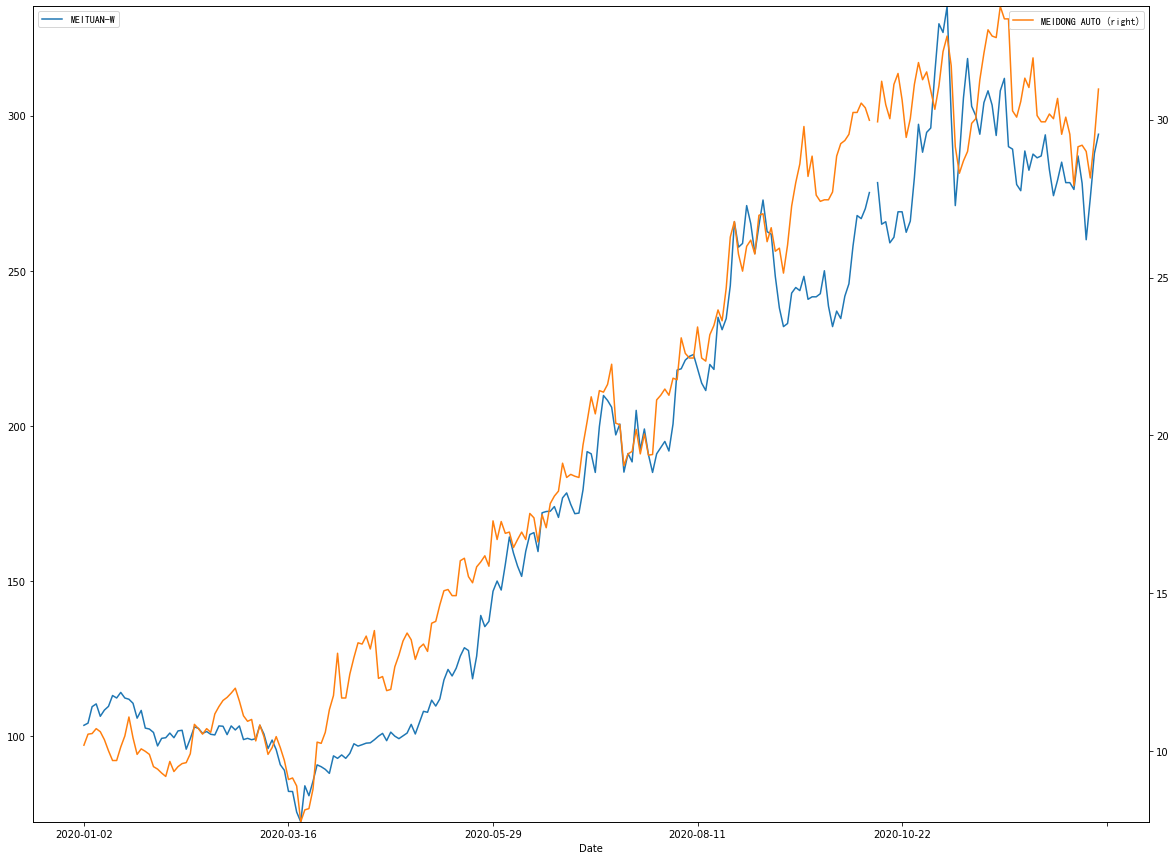

Average BUY/SELL price ratio of MEITUAN-W / MEIDONG AUTO in research period: 9.227548540108588
Entry Point (Divergence) Signal +1 (Short A Long B): Short MEITUAN-W and Long MEIDONG AUTO when the BUY/SELL price ratio > 9.688925967114017
Entry Point (Divergence) Signal -1 (Long A Short B): Long MEITUAN-W and Short MEIDONG AUTO when the BUY/SELL price ratio < 8.766171113103159
Exit Poiont (Convergence) Signal 0: Unwind the open Long/Short positions at average price ratio:  9.227548540108588
Entry Point (Divergence) Signal == -1 (Long A Short B): Long MEITUAN-W and Short MEIDONG AUTO when the BUY/SELL price ratio < 8.766171113103159
Entry Point (Divergence) Signal == 1 (Short A Long B): Short MEITUAN-W and Long MEIDONG AUTO when the BUY/SELL price ratio > 9.688925967114017
Exit Poiont (Convergence) Signal == 0 : Within the above range or Unwind the open Long/Short positions at average price ratio:  9.227548540108588
--------------------------------------------------------------------------

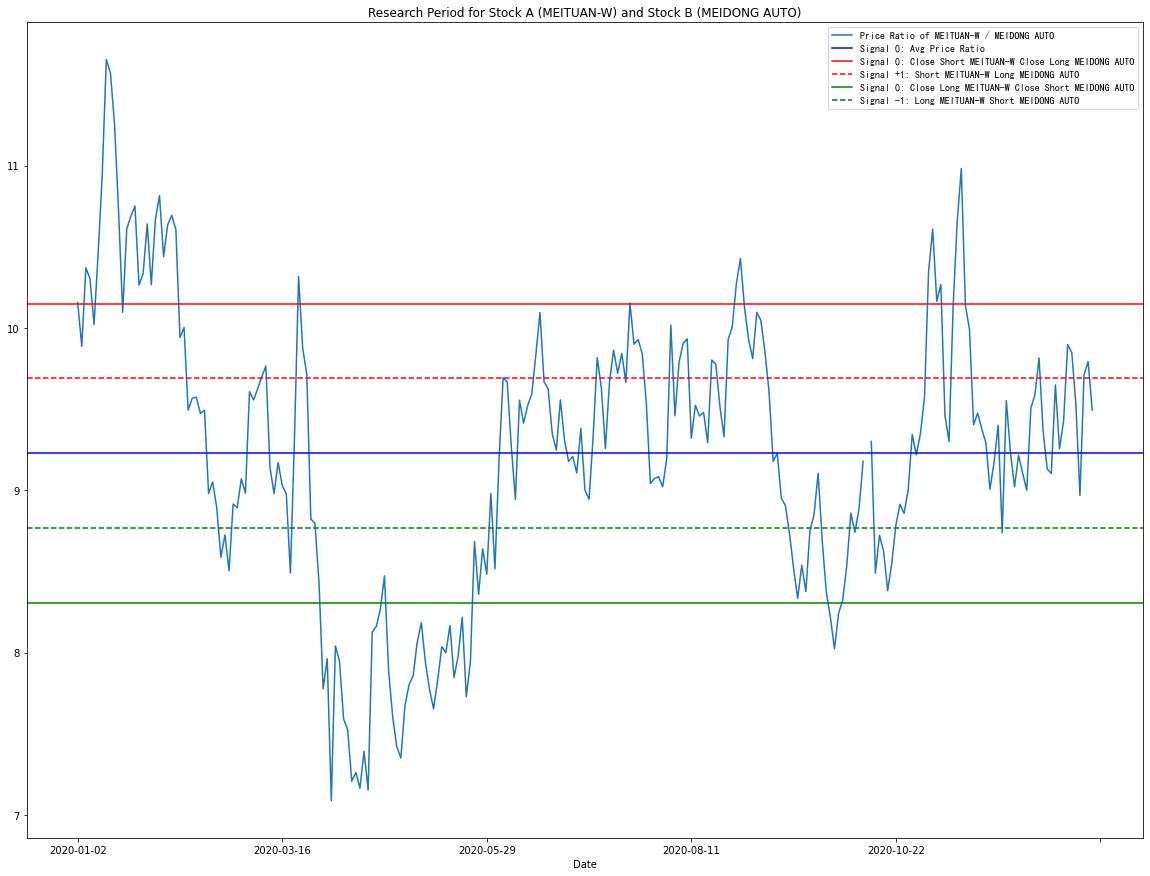

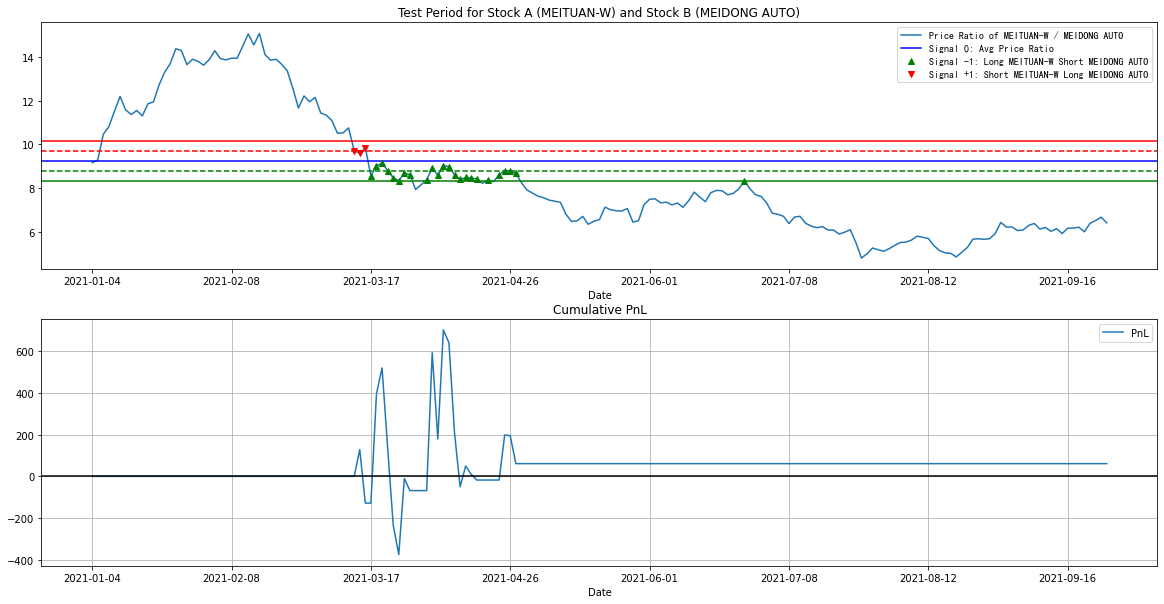

In [ ]:


# Pick a stock pair price chart to to show the price correlation
selected_pair = 1

CHART_SIZE_X, CHART_SIZE_Y = 20, 15
SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y = 8, 6
PAIR_STOCK_A = pairsDf.loc[selected_pair]['stockA']
PAIR_STOCK_B = pairsDf.loc[selected_pair]['stockB']
plotPair(researchData, PAIR_STOCK_A, PAIR_STOCK_B, CHART_SIZE_X, CHART_SIZE_Y)

# Plot all the correlated Pairs with same sector
#plotManyPair(pairsDf[(pairsDf.sameSector == True)])

# Running the price ratio which represent the relative price value
# Calculate the stock price ratios of (Stock A / Stock B) over the research period
pairResearchData = researchData[[PAIR_STOCK_A, PAIR_STOCK_B]].copy()

AB_stock = PAIR_STOCK_A + " / " + PAIR_STOCK_B
pairResearchData[AB_stock] = pairResearchData[PAIR_STOCK_A] / pairResearchData[PAIR_STOCK_B]

pairResearchData[[PAIR_STOCK_A, PAIR_STOCK_B, AB_stock]]

tradingParams = researchTradingParams(pairResearchData, PAIR_STOCK_A, PAIR_STOCK_B, PX_RATIO_THRESHOLD)

avgPxRatio = tradingParams['avgPxRatio']
longA_shortB_ratio = tradingParams['longA_shortB_ratio']
shortA_longB_ratio = tradingParams['shortA_longB_ratio']
shortA_longB_stop_loss_ratio = tradingParams['shortA_longB_stop_loss_ratio']
longA_shortB_stop_loss_ratio = tradingParams['longA_shortB_stop_loss_ratio']

print("Average BUY/SELL price ratio of", AB_stock, "in research period:", avgPxRatio)

# Plot the averge price ratio in research period
labelTitle = 'Research Period for Stock A ({}) and Stock B ({})'.format(PAIR_STOCK_A, PAIR_STOCK_B)
labelPriceRatio = 'Price Ratio of {} / {}'.format(PAIR_STOCK_A, PAIR_STOCK_B)
pairResearchData[AB_stock].plot(title=labelTitle, label=labelPriceRatio, legend=True, figsize=(CHART_SIZE_X, CHART_SIZE_Y))

labelAvgPrice = 'Signal 0: Avg Price Ratio ' 
plt.axhline(y=avgPxRatio, label=labelAvgPrice, color='b', linestyle='-')
plt.legend(loc ='upper right')

labelStopLossShortALongB = 'Signal 0: Close Short ' + PAIR_STOCK_A + ' Close Long ' + PAIR_STOCK_B
plt.axhline(y=shortA_longB_stop_loss_ratio, label=labelStopLossShortALongB, color='r', linestyle='-')

labelShortALongB = 'Signal +1: Short ' + PAIR_STOCK_A + ' Long ' + PAIR_STOCK_B
plt.axhline(y=shortA_longB_ratio, label=labelShortALongB, color='r', linestyle='--')

labelStopLossLongAShortB = 'Signal 0: Close Long ' + PAIR_STOCK_A + ' Close Short ' + PAIR_STOCK_B
plt.axhline(y=longA_shortB_stop_loss_ratio, label=labelStopLossLongAShortB, color='g', linestyle='-')

labelLongAShortB = 'Signal -1: Long ' + PAIR_STOCK_A + ' Short ' + PAIR_STOCK_B
plt.axhline(y=longA_shortB_ratio, label=labelLongAShortB, color='g', linestyle='--')

plt.legend(loc ='upper right', prop=CNFont)

print("Entry Point (Divergence) Signal +1 (Short A Long B): Short", PAIR_STOCK_A, "and Long", PAIR_STOCK_B, "when the BUY/SELL price ratio >", shortA_longB_ratio)
print("Entry Point (Divergence) Signal -1 (Long A Short B): Long", PAIR_STOCK_A, "and Short", PAIR_STOCK_B, "when the BUY/SELL price ratio <", longA_shortB_ratio)
print("Exit Poiont (Convergence) Signal 0: Unwind the open Long/Short positions at average price ratio: ", avgPxRatio)

print("Entry Point (Divergence) Signal == -1 (Long A Short B): Long", PAIR_STOCK_A, "and Short", PAIR_STOCK_B, "when the BUY/SELL price ratio <", tradingParams['longA_shortB_ratio'])
print("Entry Point (Divergence) Signal == 1 (Short A Long B): Short", PAIR_STOCK_A, "and Long", PAIR_STOCK_B, "when the BUY/SELL price ratio >", tradingParams['shortA_longB_ratio'])
print("Exit Poiont (Convergence) Signal == 0 : Within the above range or Unwind the open Long/Short positions at average price ratio: ", tradingParams['avgPxRatio'])
print("------------------------------------------------------------------------------------------------------------")
# Backtest a Pair in test period
backTest_df = backTest(testData, tradingParams, PAIR_STOCK_A, PAIR_STOCK_B)

# Calcuate the PnL in test period
print("Use the default $10,000 when entering the trade (i.e. create $10,000 long and $10,000 short exposure at the same time)")
print("Assume no transaction cost, perfect execution (can long/short at equal dollar amount), no short borrowing cost)")
pnl, pnl_df = pairslib.calcPnl(backTest_df)
print("*** PnL:", pnl)
print("==================================")
#cols = [PAIR_STOCK_A, PAIR_STOCK_B, 'pxRatio', 'signal', 'longValue', 'shortValue', 'longPos', 'shortPos', 'longPnl', 'shortPnl', 'pnl', 'totalPnl']
#pnl_df[cols].round(4)


# Plot the backtest and PnL results
pnl_df = addSignalMarker(pnl_df)
fig, axes = plt.subplots(2, 1)

labelTitle = 'Test Period for Stock A ({}) and Stock B ({})'.format(PAIR_STOCK_A, PAIR_STOCK_B)
pnl_df.pxRatio.plot(ax=axes[0], title=labelTitle, label=labelPriceRatio, legend=True)
axes[0].axhline(y=avgPxRatio, label=labelAvgPrice, color='b', linestyle='-')
pnl_df.nSignal.plot(ax=axes[0], label=labelLongAShortB, color='g', linestyle='None', marker='^', legend=True)
pnl_df.pSignal.plot(ax=axes[0], label=labelShortALongB, color='r', linestyle='None', marker='v', legend=True)

axes[0].axhline(y=longA_shortB_ratio, color='g', linestyle='--')
axes[0].axhline(y=longA_shortB_stop_loss_ratio, color='g', linestyle='-')
axes[0].axhline(y=shortA_longB_ratio, color='r', linestyle='--')
axes[0].axhline(y=shortA_longB_stop_loss_ratio, color='r', linestyle='-')
axes[0].legend(loc ='upper right', prop=CNFont)

labelTitle = 'Cumulative PnL'
pnl_df.totalPnl.plot(ax=axes[1], title=labelTitle, label='PnL', legend=True, figsize=(CHART_SIZE_X, 10), grid=True)
axes[1].axhline(y=0, color='black', linestyle='-')